In [26]:
import numpy as np
import scipy as sp
import seaborn as sns
import pystan
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, skew

In [11]:
%pylab inline

# pretty graphs
sns.set(style="whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [7]:
data = pd.read_csv("All_data/linearRegression_crimePunishment.csv")

In [8]:
data.head()

,Unnamed: 0,year,stateName,murder,car,law,state
0,1,1960,Connecticut,0.470004,4.865224,1,1
1,2,1961,Connecticut,0.000000,4.873669,1,1
2,3,1962,Connecticut,0.262364,4.984976,1,1
3,4,1963,Connecticut,0.587787,5.214392,1,1
4,5,1964,Connecticut,0.587787,5.331268,1,1


In [10]:
data.describe()

,Unnamed: 0,year,murder,car,law,state
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,270.500000,1986.500000,1.186608,5.636155,0.507407,5.500000
std,156.028843,15.600235,0.739515,0.716343,0.500409,2.874945
min,1.000000,1960.000000,-1.609438,3.975936,0.000000,1.000000
25%,135.750000,1973.000000,0.693147,5.090524,0.000000,3.000000
50%,270.500000,1986.500000,1.252763,5.592841,1.000000,5.500000
75%,405.250000,2000.000000,1.704748,6.238177,1.000000,8.000000
max,540.000000,2013.000000,2.587764,7.359531,1.000000,10.000000


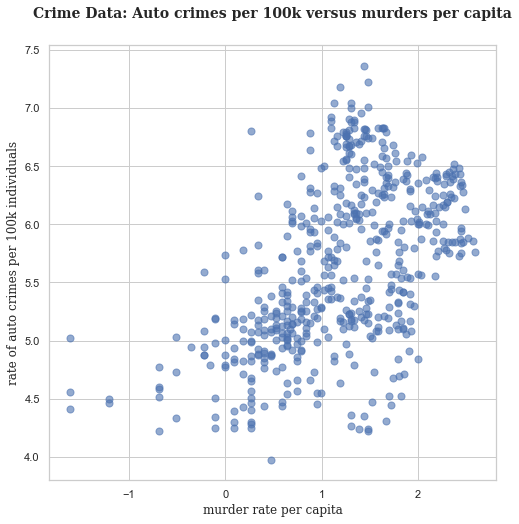

In [34]:
# plot relationship between murder rate per capita and automobile crimes per 100k individuals
# Thomas' plot
plt.figure(figsize=(8,8))
plt.scatter(data.murder,data.car,s=50, alpha=0.6)
plt.title('Crime Data: Auto crimes per 100k versus murders per capita',y=1.05,
          fontsize=14,fontfamily='serif',fontweight='bold')
plt.ylabel('rate of auto crimes per 100k individuals',fontfamily='serif')
plt.xlabel('murder rate per capita',fontfamily='serif');

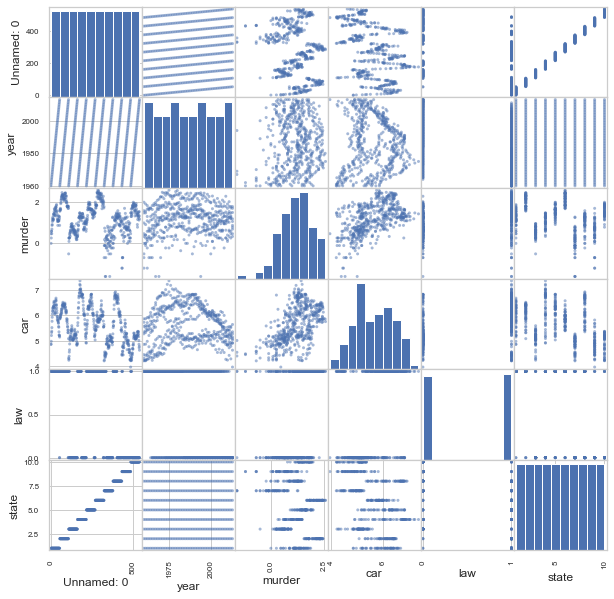

In [24]:
pd.plotting.scatter_matrix(data, alpha=0.5, figsize=(10, 10))
plt.show()

So it looks like there is some sort of positive correlation between murder rate and rate of auto crimes. There also may be something interesting going on at the state level... but not totally sure what yet. As years increase, car crimes first start to increase, then decrease. The murder rate as time goes on is all over the place. 

Also looks like if there's cap. punishment allowed (law=1), the car crimes and murder rate actually look like they could potentially be higher (would be good to do box plots or something)

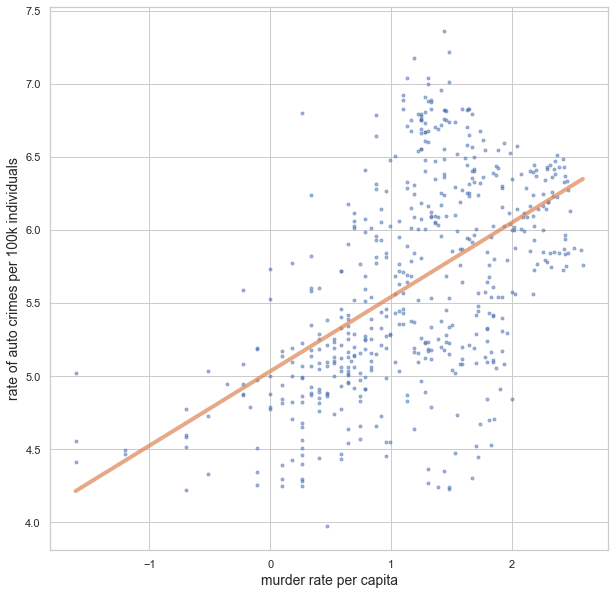

In [37]:
# joe's plot
figsize(10,10)
slope, intercept, *_ = linregress(data.murder, data.car)
full_x = np.array([data.murder.min(), data.murder.max()])
full_y = slope*full_x+intercept

plt.plot(data.murder, data.car, ".", alpha=0.5)
plt.plot(full_x, full_y, lw=4, alpha=0.7)

plt.xlabel("murder rate per capita", fontsize=14)
plt.ylabel("rate of auto crimes per 100k individuals", fontsize=14);

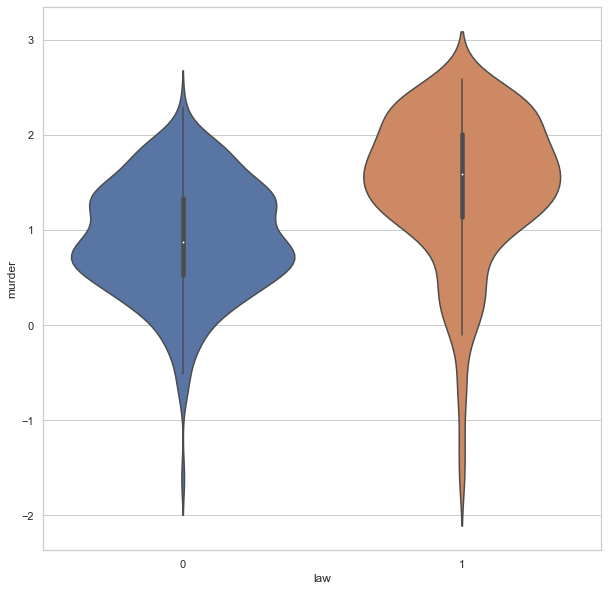

In [38]:
ax = sns.violinplot(x="law", y="murder", data=data)

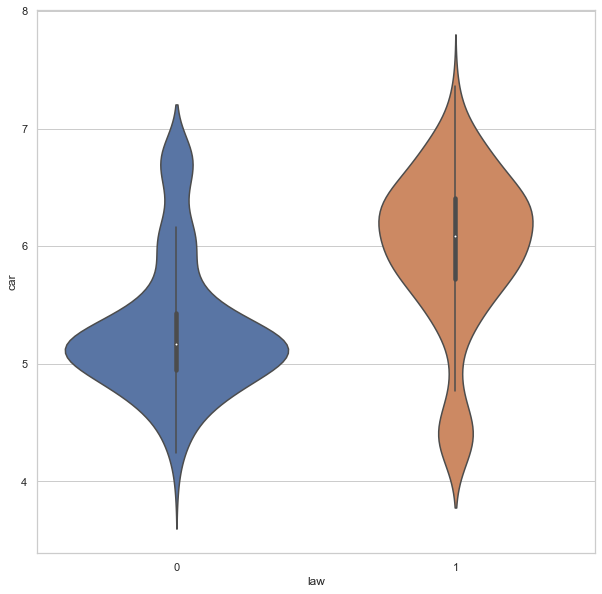

In [39]:
ax = sns.violinplot(x="law", y="car", data=data)

Could also be cool to plot the two different distributions for law=0 and law=1 on top of each other to see what they look like. 

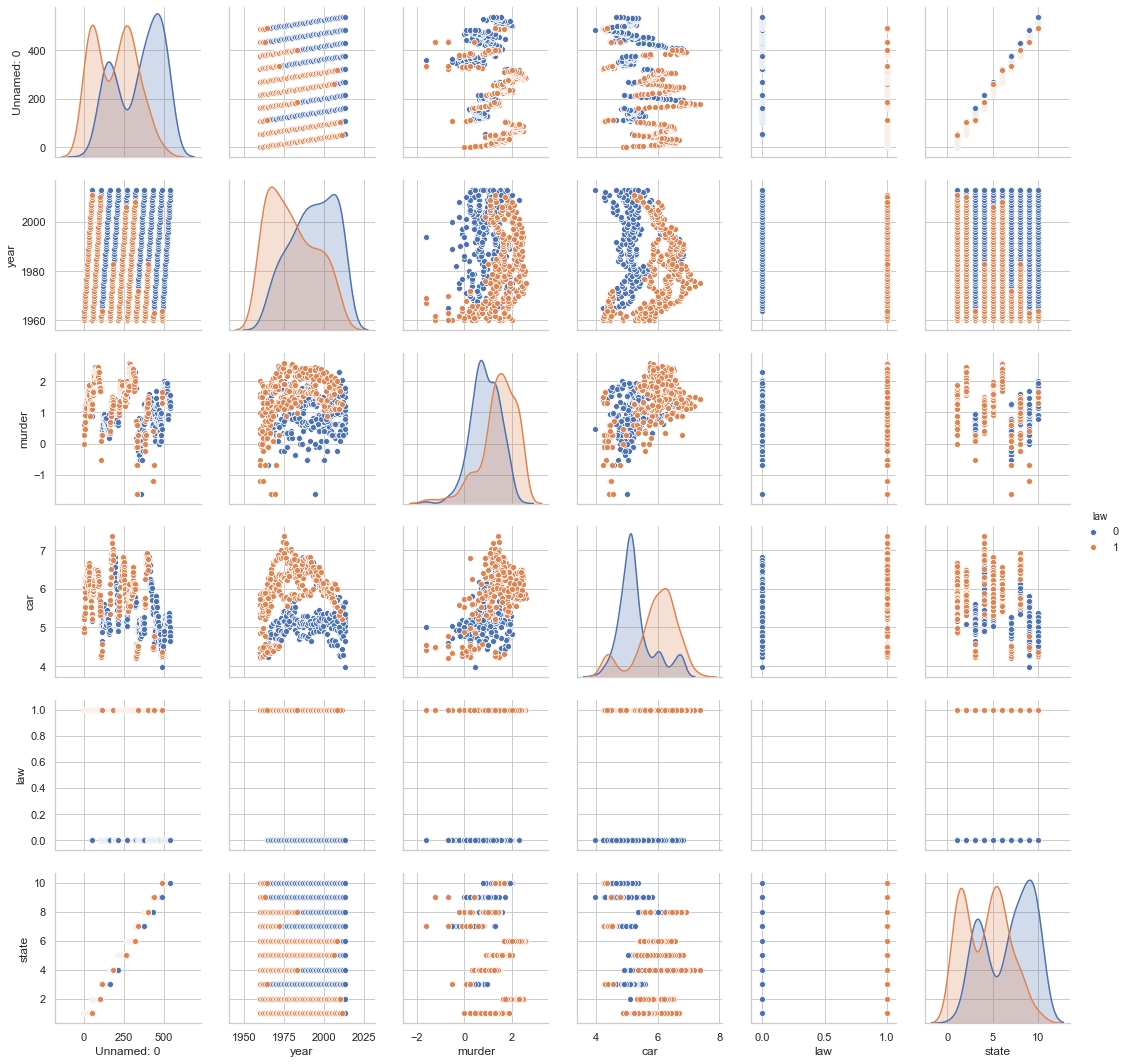

In [42]:
sns.pairplot(data, hue="law")

So the distributions do look different for law=0 vs. law=1. 

In [82]:
# a stan model for linear regression
f = open('crime_model.stan', 'r')
file_contents = f.read()
print (file_contents)
f.close()

// fit a linear regression model to the murder rate
data {
  int<lower=1> N; // number of datapoints
  real murder[N];    // random variable
  real penalty[N]; //law about death penalty
  real car[N]; 
}
parameters {
  real alpha;
  real beta;
  real gamma;
  real<lower=0> sigma;
}
model {
  for(i in 1:N){
      murder[i] ~ normal(alpha + beta*penalty[i] + gamma*car[i], sigma);
  }
  // priors
  alpha ~ normal(0,1);
  beta ~ normal(0,1);
  gamma ~ normal(0,1);
  sigma ~ normal(0,2); 
}
generated quantities {
  vector[N] murder_sim;    // simulated values from the posterior
  
  for (n in 1:N) {
    real murder_hat_n = alpha + beta * penalty[n] + gamma * car[n];
    murder_sim[n] = normal_rng(murder_hat_n, sigma);
  }
      
}



In [83]:
lr = pystan.StanModel(file='crime_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c95493b6f9d512509fd5bb2b7f27add1 NOW.


In [84]:
# feed stan some data
murder_dict = {'N':len(data.murder),'murder':data.murder, 'penalty':data.law, 'car':data.car}

In [85]:
# conduct MCMC using Stan
murder_draws = lr.sampling(data=murder_dict, iter=1000, chains=4)

In [86]:
# give us a dictionary containing posterior draws for each parameter in the model
murder_pstr = murder_draws.extract(permuted=True)

In [87]:
murder_draws


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_c95493b6f9d512509fd5bb2b7f27add1.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha           -1.48  9.1e-3   0.22   -1.9  -1.62  -1.48  -1.33  -1.04    601    1.0
beta             0.24  1.9e-3   0.06   0.12    0.2   0.24   0.28   0.36    927    1.0
gamma            0.45  1.7e-3   0.04   0.37   0.42   0.45   0.48   0.53    574   1.01
sigma            0.62  6.9e-4   0.02   0.59   0.61   0.62   0.64   0.67    796    1.0
murder_sim[1]    0.95    0.02   0.63  -0.25   0.52   0.94   1.38   2.28   1719    1.0
murder_sim[2]    0.95    0.01   0.62  -0.29   0.52   0.95   1.38   2.14   2221    1.0
murder_sim[3]     1.0    0.01   0.63  -0.23   0.56    1.0   1.41   2.25   1833    1.0
murder_sim[4]    1.14    0.01   0.61  -0.03   0.73   1.14   1.54   2.34   1989    1.0

In [88]:
alpha_samples = murder_draws.extract()["alpha"]
beta_samples = murder_draws.extract()["beta"]
gamma_samples = murder_draws.extract()["gamma"]
sigma_samples = murder_draws.extract()["sigma"]
murder_sim = murder_draws.extract()["murder_sim"]

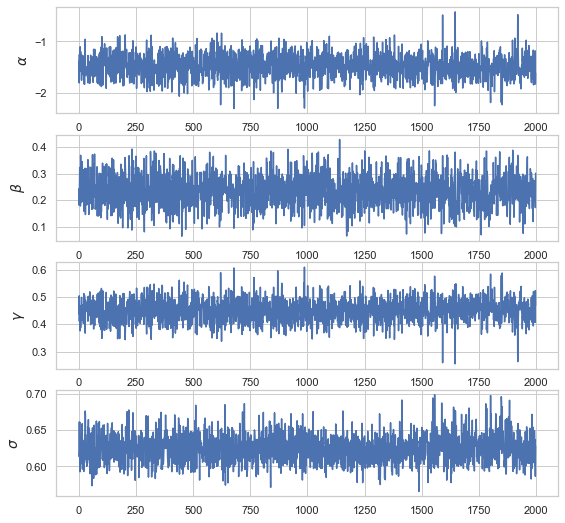

In [89]:
# trace plot
figsize(9,9)
plt.subplot(4,1,1)
plt.plot(alpha_samples)
plt.ylabel("$\\alpha$", fontsize=14)
plt.subplot(4,1,2)
plt.plot(beta_samples)
plt.ylabel("$\\beta$", fontsize=14)
plt.subplot(4,1,3)
plt.plot(gamma_samples)
plt.ylabel("$\\gamma$", fontsize=14);
plt.subplot(4,1,4)
plt.plot(sigma_samples)
plt.ylabel("$\\sigma$", fontsize=14);